### Convolutional VAEs for CIFAR-10 dataset

#### Libraries

In [1]:
import numpy as np
import numpy as np
import time
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras, random, nn
from tensorflow import data
from keras import Model, Sequential, optimizers, metrics
from keras.layers import InputLayer, Dense, Conv2D, Conv2DTranspose, Reshape, Flatten

2023-04-11 10:22:29.444413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### GPU/CPU settings

In [2]:
gpu_device = tf.test.gpu_device_name()
cpu_device = '/cpu:0'

2023-04-11 10:22:35.739418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# set CPU the device for now
device = cpu_device

In [ ]:
if gpu_device != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(gpu_device))

#### Congif Hyper-Parameters

In [5]:
epochs = 10
batch_size = 32
latent_dim = 128

#### Data Pre-processing

In [8]:
def load_cifar_data():
    (x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
    return x_train, x_test

def preprocess_digits_image_data(data):
    # reshape, normalize, and binarize (gray) data
    shape = data.shape
    image_data = data.reshape((shape[0], shape[1], shape[2], shape[3])) / 255.
    return np.where(image_data < 0.5, 0.0, 1.0).astype('float32')

In [16]:
# get data (n, 32, 32, 3)
x_train, x_test = load_cifar_data()

# preprocess data
x_train = preprocess_digits_image_data(x_train)
x_test = preprocess_digits_image_data(x_test)

#### Split datasets

In [18]:
def split_batch(image_data, batch_size):
    data_size = len(image_data)
    return (data.Dataset.from_tensor_slices(image_data).shuffle(data_size).batch(batch_size))

# split data into batches
x_train = split_batch(image_data=x_train, batch_size=batch_size)
x_test  = split_batch(image_data=x_test, batch_size=batch_size)

#### Define VAEs

In [60]:
'''Basic Convolutional VAE'''
class VAE(Model):

    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.generate_encoder()
        self.decoder = self.generate_decoder()

    def generate_encoder(self):
        return Sequential([
            InputLayer(input_shape=(32, 32, 3)),
            Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu'),
            Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu'),
            Flatten(),
            # because the output of encoder has two parts, the mean and 
            # log-variance of the posterior distribution q(z|x)
            Dense(self.latent_dim * 2)
        ])
    
    def generate_decoder(self):
        return Sequential([
            # the input to decoder is z sampled from the Gaussian (through 
            # reparameterization trick)
            InputLayer(input_shape=(self.latent_dim,)),
            Dense(units=32*7*7, activation='relu'),
            Reshape(target_shape=(7,7,32)),
            Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
            Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
            Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')
        ])

    def encode(self, x):
        with tf.device(device):
            mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
            return mean, logvar
    
    def reparameterize(self, mean, logvar):
        with tf.device(device):
            e = random.normal(shape=mean.shape)
            z = mean + e * tf.exp(logvar * 0.5)
            return z

    def decode(self, z):
        with tf.device(device):
            xhat = self.decoder(z)
            return xhat
    
    '''used during inference'''
    def sample(self, rand_vec=None):
        with tf.device(device):
            if rand_vec == None:
                rand_vec = random.normal(shape=(100, self.latent_dim))
            return tf.sigmoid(self.decode(rand_vec)) # binarize the result for visibility

In [61]:
# define and train model
vae = VAE(latent_dim=latent_dim)

#### Define preliminary methods

To construct our loss function, let us define a few variables as follows: 
1. $x$: input data, or evidence (in our case, images)
2. $z$: sampled latent representation from $p(z|x)$
3. $p(x)$: evidence distribution
4. $p(z)$: prior distribution
5. $p(z|x)$: posterior distribution, which defines the encoder of our VAE
6. $p(x|z)$: likelihood probability, which defines the decoder of our VAE

Following the reference, we have the loss function given by $$\text{loss} = C||x-\hat{x}||^2 + \text{KL}(N(\mu_{x}, \theta_{x}), N(0,1)),$$
where KL is the KL divergence of the two Gaussians and $C > 0$. We use $\hat{x}$ to denote the likelihhod pobability p(x|z), and assume that $p(z)$ follows the standard Gaussian and $p(z|x)$ follows a Gauussian characterized by the two output of the encoder network (the mean and log variance). Because $p(z|x)$ is intractable, we use $q(z|x) to denote the approximation of $p(z|x)$. Overall, this loss in very interpretable, as the first likelihood term characterizes the construction error (it does not need to be MSE, and we use cross entropy in our code) and the second KL term is for the regularization of the network (so that our latent space becomes more continuous and complete, which enables the generative proceedur).

Now, rather than implementating this loss function, we will construct another loss function that is more easily implementable. Our objective function is (not the loss)
$$\text{argmin}\left[C||x-\hat{x}||^2 + KL\left(q(z|x), p(z)\right)\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}p(x|z)\right] - KL\left(q(z|x), p(z)\right)\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}p(x|z)\right] + \int q(z|x)\text{log}\left(\frac{p(z)}{q(z|x)}\right)\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}p(x|z)\right] + \mathbb{E}_{z \sim q(z|x)}\text{log}\left(\frac{p(z)}{q(z|x)}\right)\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}p(x|z) + \text{log}\left(\frac{p(z)}{q(z|x)}\right)\right]\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}\left(\frac{p(x|z)p(z)}{q(z|x)}\right)\right]\right]$$
$$= \text{argmax}\left[\mathbb{E}_{z \sim q(z|x)}\left[\text{log}p(x|z) + \text{log}p(z) - \text{log}q(z|x)\right]\right].$$

This objective function gives a new loss
$$\text{loss} = \text{log}p(x|z) + \text{log}p(z) - \text{log}q(z|x).$$

In [62]:
def log_normal(sample, mean, logvar):
    with tf.device(device):
        prob = -0.5 * ((sample - mean) ** 2.0 * tf.exp(-logvar) + logvar + tf.math.log(2.0 * np.pi))
        return tf.reduce_sum(prob, axis=1)

def get_loss(model, x):
    with tf.device(device):
        mean, logvar = model.encode(x) # defining q(z|x)
        z = model.reparameterize(mean, logvar) # sampled from q(z|x)
        xhat = model.decode(z) # generated by obtaining p(x|z)
        prob = nn.sigmoid_cross_entropy_with_logits(labels=x, logits=xhat)

        logpxz = -tf.reduce_sum(prob, axis=[1,2,3]) # just reconstruction error
        logpz = log_normal(z, mean, logvar) # standard Gaussian (assumed)
        logqzx = log_normal(z, mean, logvar) # Gaussian obtained through encoder

        # return the average value for each sample within this batch
        return -tf.reduce_mean(logpxz + logpz - logqzx)

#### Training and generating

In [63]:
'''use Adam'''
def train_per_batch(model, x):
    optimizer = optimizers.Adam(learning_rate=1e-4)
    with tf.device(device):
        with tf.GradientTape() as gt:
            loss = get_loss(model, x)
            gradient = gt.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradient, model.trainable_variables))
        return loss

def train(model, epochs, x, x_test=None):
    # for each epoch
    with tf.device(device):
        for epoch in range(epochs):
            start_time = time.time()
            train_loss = metrics.Mean()
            for x_batch in x:
                train_loss(train_per_batch(model, x_batch))
            time_elapsed = time.time() - start_time
            loss = train_loss.result()
            if math.isnan(loss):
                print('ERROR: loss is not computable')
                exit(0)
            print(f'Epoch: {epoch}, train loss: {loss}, time elapsed: {time_elapsed}')

            if x_test is not None:
                for test_batch in x_test:
                    x_sample = test_batch[0:16,:,:,:]
                    break
                pred = predict(model, x_sample)
                save_img(pred, 'test_epoch'+str(epoch))

def predict(model, x):
    with tf.device(device):
        mean, logvar = model.encode(x)
        z = model.reparameterize(mean, logvar) 
        return model.sample(z) 

def save_img(pred, file):
    plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(pred[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.savefig(f'./generated_images/{file}.png')

In [ ]:
# train model
train(model=vae, epochs=epochs, x=x_train_digits)

#### Generated Images

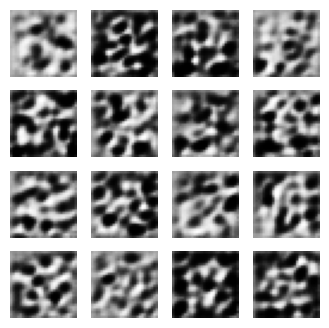

In [44]:
def generate(model):
    with tf.device(device):
        random_vector_z = tf.random.normal(shape=[16, model.latent_dim])
        generated = model.sample(random_vector_z)
        return generated

generated_imgs = generate(model=vae)
save_img(generated_imgs, f'latent{latent_dim}_epoch{epochs}_batch{batch_size}')